### KEM
This is a simulation of an economic micro interations, in which each time step two actors, which are chosen by an interaction function, engage in a transaction that exchanges wealth between them according to a specific transaction function.

This code has been modified from https://nbviewer.jupyter.org/url/norvig.com/ipython/Economics.ipynb

In [1]:
import random
%matplotlib inline
import matplotlib.pyplot as plt
import statistics
import warnings
import numpy as np
import copy
from matplotlib.animation import FuncAnimation

warnings.filterwarnings("ignore")

In [102]:
#initial values (population size & mean of the income distribution)
N  = 500
MU = 100. 

# Initial income distribution

def normalize(numbers, mu):
    
    '''
    Positive values, and scale them so they have mean mu.
    
    '''
    
    numbers = [max(0, n) for n in numbers]
    
    factor = len(numbers) * mu / sum(numbers)
    
    return [x * factor for x in numbers]

def samples(distribution, *args, n = N, mu = MU):
    '''
    Sample from the distribution n times,
    then normalize results.
    
    '''
    
    numbers = [distribution(*args) for _ in range(N)]
    return normalize(numbers, mu)


population = [np.random.uniform(0, 100) for actor in range(N)]
#TODO: use from paper, find value
#lambda_ = np.random.lognormal(-1.5, 0.45, N)
lambda_ = np.random.pareto(7., N)
i = 0
# make sure no lambdas are above 1
for l in lambda_:
    if l >=1.:
        lambda_[i] = np.random.pareto(7.)
        if lambda_[i]>=1.:
            lambda_[i] = 0.9
    i+=1

In [63]:
population

float

In [33]:
lambda_

array([0.59465836, 0.18397236, 0.23757643, 0.2315604 , 0.12959242])

In [34]:
print((np.argmax(lambda_)))
print(np.max(lambda_))

0
0.5946583603565263


In [9]:
def gini(p):
    
    "Gini coefficient (equation from wikipedia)"
    
    y = sorted(p)
    n = len(p)
    
    numer = 2 * sum((i+1) * y[i] for i in range(n))
    denom = n * sum(y)
    
    return (numer / denom) - (n + 1) / n


In [56]:
def hist(population, label='Dist', **kwargs):
    label = label + ': G=' + str(round(gini(population), 2))
    
    h = plt.hist(list(population), alpha = 0.4, bins = 30, label= label, **kwargs)
    
    plt.xlabel('Wealth')
    plt.ylabel('Count')
    plt.grid(True)
    
    plt.legend()

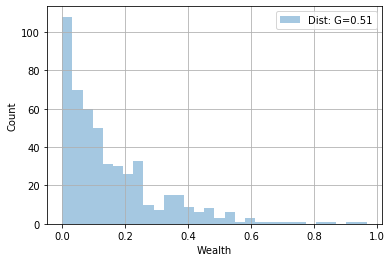

In [103]:
hist(lambda_)

In [73]:
# Type of Transactions

def swd(A, B):
    # this need to change after
    eps = np.random.uniform()
    
    
    return lambda_[A]*population[A] + eps*((1-lambda_[A]) * population[A] + (1 - lambda_[B])*population[B]), lambda_[B]*population[B] + (1-eps)*((1 - lambda_[A]) * population[A] + (1 - lambda_[B])*population[B]) 
    


In [12]:
# Type of Interactions 

def anyone(N): 
    '''
    Takes two actors randomly
    
    '''
    return random.sample(range(N), 2)

In [13]:
# Simulation

def simulate(population, steps, transaction=swd, interaction=anyone):
    '''
    Simulate takes a certain initial population, and makes them interact.
    
    Inputs:
        population. list. Initial income distribution
        steps. int. Time steps to execute the simulation
        transaction. function. function that describes the dynamic of the transaction.
        interaction. function. function that describes the dynamic of the interaction.
    
    Outputs:
        population after steps number of steps. 
    
    '''
    
    population = population.copy()
   # yield population
 
    for t in range(steps):
        i, j = interaction(len(population))
        population[i], population[j] = transaction(i,j)
        
        yield population
        

In [68]:
def show(population, k=500, percentiles=(1, 10, 50, 90, 99), **kwargs):
    
    '''
    Run a simulation for k*N steps, 
    printing statistics and displaying a plot and histogram.
    
    '''
    
    N = len(population)
    start = list(population)
    
#     results = [(t, sorted(pop)) # Sort results so that percentiles work
#                 for (t, pop) in enumerate(simulate(population, k * N, **kwargs))
#                 if t % (N / 10) == 0]
    
    results = []
    sorted_results = []
    times = []
    
    
    for (t, pop) in enumerate(simulate(population, k * N, **kwargs)):
#         print("first:",pop)
#         print(results)
        if t % (N / 10) == 0:
            results.append(copy.copy(pop))
            sorted_results.append(sorted(pop))
            times.append(copy.copy(t))
            #print("second:",pop)
                           
    #print(results)

    
#     lists = [pop[0] for (t, pop) in results]
#     print(lists)
    
    
    # see above: times = list(range(1,k*N+1))#[t for (t, pop) in results]

    
    
    # Statistics
    
    print('   t    Gini stdev' + (' {:3d}%' * len(percentiles)).format(*percentiles))
    
    
    fmt = '{:7,d} {:.2f} {:5.1f}' + ' {:4.0f}' * len(percentiles)
    
    
    initsum = sum(population)
    for (t, pop) in zip(times,sorted_results):
        err = (sum(pop) - initsum)/initsum
        #print(err)
        if t % (4 * N) == 0:
            #NOT EQUAL TO SAME SUM EVERY TIME!!! but close??? 
           
            data = [percent(pct, pop) for pct in percentiles]
            print(fmt.format(t, gini(pop), statistics.stdev(pop), *data))
            
            
#     #plot individual trajectory
#     plt.hold(True)
#     plt.xlabel('Time')
#     plt.ylabel('Wealth')
#     plt.grid(True)
#     plt.plot(times, lists)

#     plt.show()
    
    
    
    
    
    # Plot
    
    #JAKE COMMENTED 
    #plt.hold(True)
    plt.xlabel('Time')
    plt.ylabel('Wealth')
    plt.grid(True)
    
    for pct in percentiles:
        #TODO: this should average over all people in different percentiles, or make a separate thing to do that
        line = [percent(pct, pop) for pop in results]
        plt.plot(times, line)

    plt.show()
    
    
    # Histogram
    
    R = (min(pop+start), max(pop+start))
    hist(start, 'Initial', range=R)
    hist(pop, 'Final', range=R)
    
    return results
                
def percent(pct, items):
    '''
    The item that is pct percent through the sorted list of items.
    
    '''
    return items[min(len(items)-1, len(items) * pct // 100)]



def animate_distributions(pop_series,continuous=True,times=[0,1],n_frames=100):
    #if continuous:
    run_times = []
    
    
    duration = times[1]-times[0]
    tstep = round(float(duration)/n_frames)
    
    max_t = len(pop_series)

#     fig = plt.figure()
#     ax = plt.axes(xlim=(0, max(max(pop_series))), ylim=(0, 65))
#     hst, = ax.hist([])
    fig = plt.figure()
    #hist = plt.hist(pop_series[0])
#     def init():
#         hst.set_data([])
#         return hst,
    def animate(i):
        #label = label + ': G=' + str(round(gini(population), 2))
        plt.cla()
        time = times[0]+i*tstep
        if time < max_t:
            plt.hist(pop_series[time], alpha = 0.4, bins = 30, label=str(time))
            plt.legend()
            plt.xlabel('Wealth')
            plt.ylabel('Count')
            plt.grid(True)


       
        #hist(pop_series[i])
        #line.set_data(pop_series[i])
        #return line,

    anim = FuncAnimation(fig, animate, #init_func=init,
                                   frames=n_frames)#), interval=20)#, blit=True)
    return anim
    #plt.show()
    

   t    Gini stdev   1%  10%  50%  90%  99%
      0 0.34  29.7    1   10   48   91   99
  2,000 0.39  35.9    3   10   45  105  146
  4,000 0.41  35.6    3    9   42  100  143
  6,000 0.40  35.3    2   10   42  103  150
  8,000 0.39  33.8    3   10   41   97  145
 10,000 0.37  33.6    1   10   43  100  141
 12,000 0.38  33.8    3   10   44   98  144
 14,000 0.38  34.4    2   10   45   96  149
 16,000 0.39  33.3    2   11   41   97  140
 18,000 0.38  34.6    3   10   44   97  162
 20,000 0.39  34.8    3   11   44   98  152
 22,000 0.38  34.3    2   10   44   98  148
 24,000 0.41  36.6    2    9   41  103  150
 26,000 0.39  34.8    2   11   40   99  151
 28,000 0.39  35.0    2   11   42   99  152
 30,000 0.38  33.7    3    9   43   99  137
 32,000 0.39  35.6    2   10   42  106  140
 34,000 0.38  34.7    3   10   43  100  152
 36,000 0.38  33.1    3   11   45   96  140
 38,000 0.38  34.7    2   10   46  100  140
 40,000 0.39  33.5    2   10   45   96  136
 42,000 0.37  33.5    3   11   4

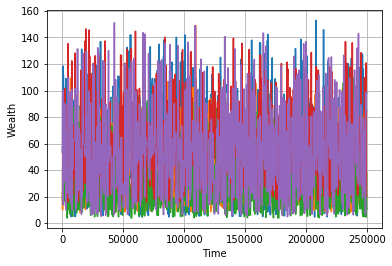

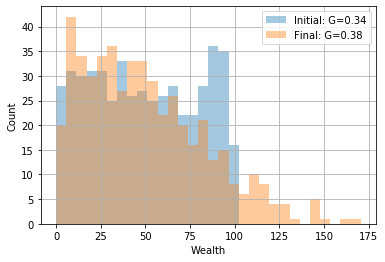

In [104]:
results = show(population)


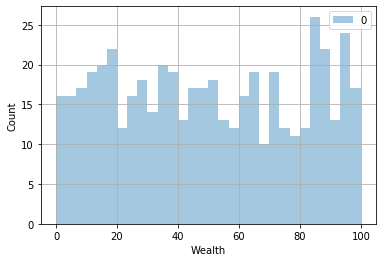

In [105]:

animation = animate_distributions(results,continuous=True,times=[0,200],n_frames=100)
from IPython.display import HTML
HTML(animation.to_jshtml())
#ani.save('test.gif', writer='imagemagick')

In [69]:
#     def show(population, k=1, **kwargs):
    
#     '''
#     Run a simulation for k*N steps, 
#     printing statistics and displaying a plot and histogram.
    
#     '''
    
#     N = len(population)
#     results = [list(simulate(population, k*N, **kwargs))]
    
# #     for (t, pop) in enumerate(simulate(population, k*N, **kwargs)): 
# #         if t % (N/10) ==0:
# #             results.append((t, pop))
    
    
# #     times = [t for (t, pop) in results]
    
#     print(results)
    
    
#     plt.hold(True)
#     plt.xlabel('Time')
#     plt.ylabel('Wealth')
#     plt.grid(True)
    
#     plt.plot()
#     plt.show()


In [70]:
show(population)

[[[73.82647493883739, 48.00267646858903, 4.45256058669142, 64.33629331218319, 99.6524917123641], [73.82647493883739, 48.00267646858903, 4.45256058669142, 64.33629331218319, 99.6524917123641], [73.82647493883739, 48.00267646858903, 4.45256058669142, 64.33629331218319, 99.6524917123641], [73.82647493883739, 48.00267646858903, 4.45256058669142, 64.33629331218319, 99.6524917123641], [73.82647493883739, 48.00267646858903, 4.45256058669142, 64.33629331218319, 99.6524917123641], [73.82647493883739, 48.00267646858903, 4.45256058669142, 64.33629331218319, 99.6524917123641]]]
